# Amazon project - Employee Access Challenge

| Column name | Description |
| --- | --- |
| ACTION | 1, если ресурс был утвержден, 0, если ресурс не был |
| RESOURCE | Идентификатор ресурса |
| MGR_ID | Идентификатор руководителя данного работника - у работника может быть только один руководитель |
| ROLE_ROLLUP_1 | Идентификатор категории группы профессий/ролей компании 1 (US Engineering)  |
| ROLE_ROLLUP_2 | Идентификатор категории группы профессий/ролей компании 2 (US Retail) |
| ROLE_DEPTNAME | Название отдела (Retail) |
| ROLE_TITLE | Название роли в этой компании (Senior Engineering Retail Manager) |
| ROLE_FAMILY_DESC | Расширенное описание профессии (Retail Manager, Software Engineering) |
| ROLE_FAMILY | Описание роли/профессии, название (Retail Manager) |
| ROLE_CODE | Код компании; этот код уникален для каждой роли |

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [28]:
train = pd.read_csv("C:/Users/Lenovo/Downloads/data/train.csv")
test = pd.read_csv("C:/Users/Lenovo/Downloads/data/test.csv")

y = train["ACTION"]

In [30]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
id                  58921 non-null int64
RESOURCE            58921 non-null int64
MGR_ID              58921 non-null int64
ROLE_ROLLUP_1       58921 non-null int64
ROLE_ROLLUP_2       58921 non-null int64
ROLE_DEPTNAME       58921 non-null int64
ROLE_TITLE          58921 non-null int64
ROLE_FAMILY_DESC    58921 non-null int64
ROLE_

In [31]:
# Чтобы узнать разброс значений, среднюю стоимость и медиану в каждом из признаков, используем метод .describe():
train.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


In [70]:
# Проверим, имеются ли пустые, незаполненные ячейки в тренировочной выборке
train.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [100]:
# Наблюдаем баланс выборки и как распределены данные в тренировочной выборке по искомому критерию
train.groupby('ACTION').count()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
ACTION,,,,,,,,,
0,1897,1897,1897,1897,1897,1897,1897,1897,1897
1,30872,30872,30872,30872,30872,30872,30872,30872,30872


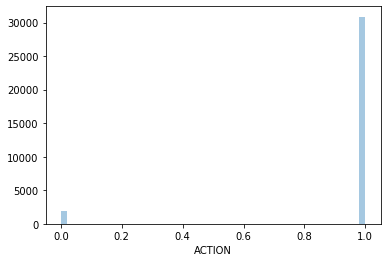

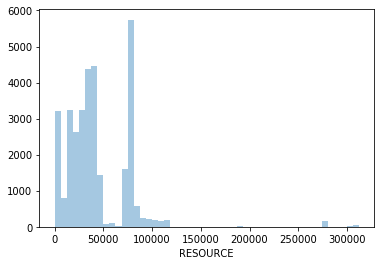

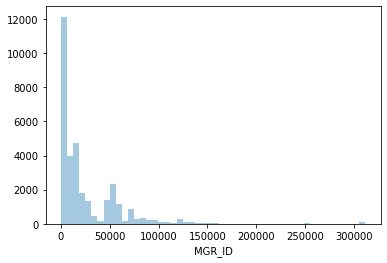

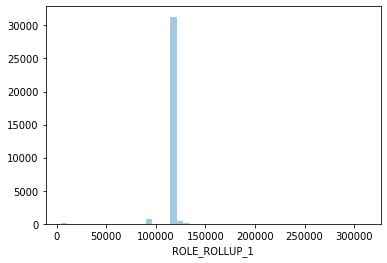

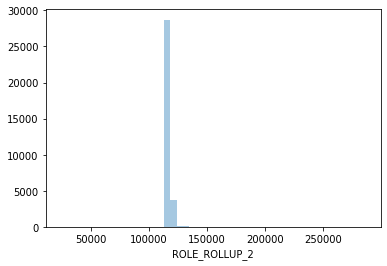

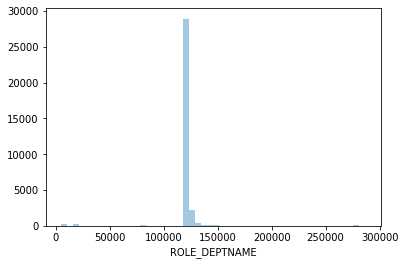

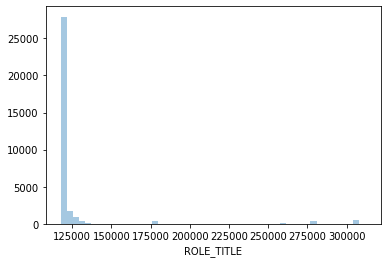

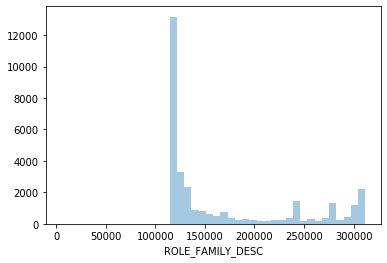

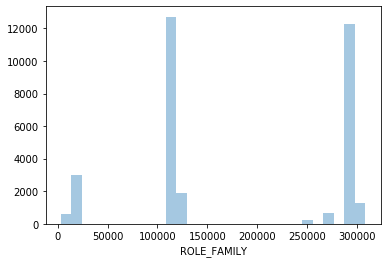

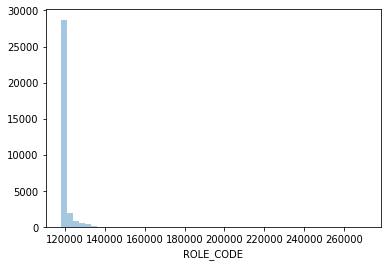

In [76]:
for i in train.var().index:
    sns.distplot(train[i],kde=False)
    plt.show()

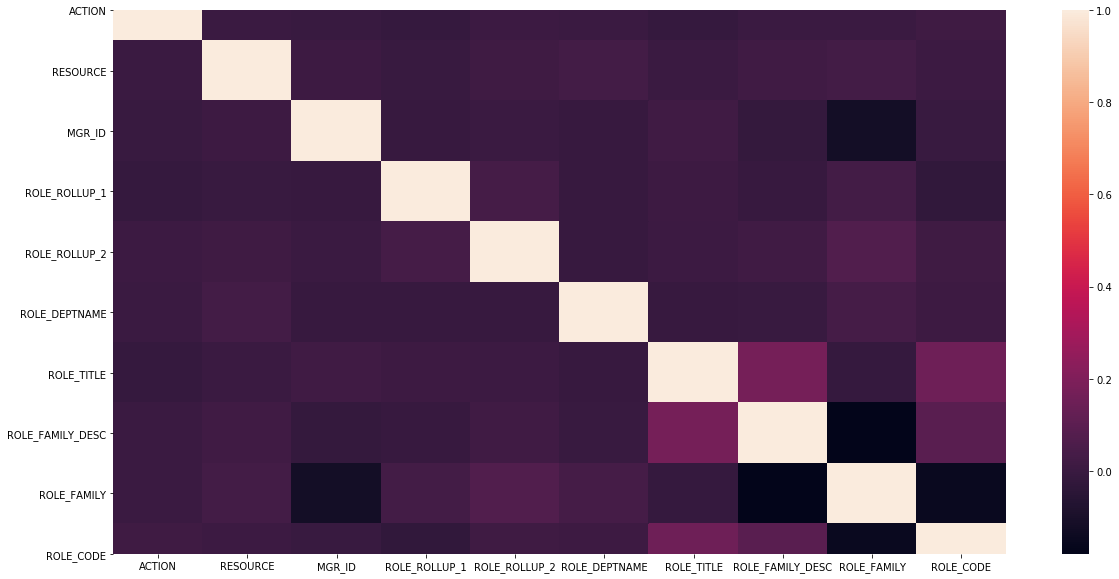

In [72]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr())

In [116]:
y_train = train['ACTION']
x_train = train[train.columns.difference(['ACTION'])]
x_test = test


# Base classifiers

In [104]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_train)
accuracy_score(y_train,predictions)

0.9421099209618847

In [40]:
clf = DummyClassifier(strategy='uniform',random_state=0)
clf.fit(x_train, y_train)
clf.score(x_train,y_train)


0.4990387256248283

In [115]:
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(x_train, y_train)
clf.score(x_train,y_train)

0.8905978211114163

#### Благодаря использованию вышеописанных классификаторов, а также просмотру описательных характеристик данных, мы видим, что выборка несбалансированна, поэтому мы можем не рассматривать некоторые методы, дающие качественную оценку только на сбалансированных данных 


## Часть 2.

##### Decision Tree Classifier

In [129]:
model = DecisionTreeClassifier()
X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.20,random_state=43)
model.fit(X_train,Y_train)
model.predict(X_test)
model.predict(X_train)
print(confusion_matrix(Y_test,model.predict(X_test)))
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,model.predict(X_train)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,model.predict(X_train)))

[[ 158  213]
 [ 238 5945]]
Accuracy Score of test dataset
0.9311870613365884
Confusion matrix of train model
[[ 1526     0]
 [    0 24689]]
Accuracy Score of train dataset
1.0


[Text(167.4, 190.26, 'X[4] <= 68840.0\nentropy = 0.32\nsamples = 26215\nvalue = [1526, 24689]'),
 Text(83.7, 135.9, 'X[7] <= 117961.0\nentropy = 0.477\nsamples = 2905\nvalue = [298, 2607]'),
 Text(41.85, 81.53999999999999, 'X[1] <= 38164.5\nentropy = 0.261\nsamples = 838\nvalue = [37, 801]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.323\nsamples = 561\nvalue = [33, 528]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 0.109\nsamples = 277\nvalue = [4, 273]'),
 Text(125.55000000000001, 81.53999999999999, 'X[5] <= 61276.0\nentropy = 0.547\nsamples = 2067\nvalue = [261, 1806]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.997\nsamples = 15\nvalue = [8, 7]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.539\nsamples = 2052\nvalue = [253, 1799]'),
 Text(251.10000000000002, 135.9, 'X[4] <= 262441.5\nentropy = 0.298\nsamples = 23310\nvalue = [1228, 22082]'),
 Text(209.25, 81.53999999999999, 'X[0] <= 1722.0\nentropy = 0.248\nsamples = 11899\nvalue = [491, 11408]'),
 Tex

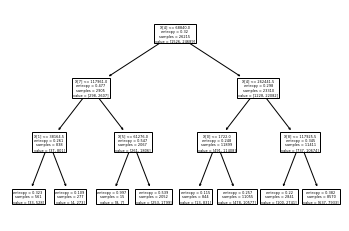

In [125]:
from sklearn import tree
tree.plot_tree(model.fit(X_train, Y_train)) # вывод дерева

\begin{equation*}
\frac{TP+TN}{{P + N}} =\frac{TP+TN}{{TP + TN +FP +FN}}
\end{equation*}

\begin{equation*}
Precision =\frac{TP}{{TP + FP}}
\end{equation*}

\begin{equation*}
Recall =\frac{TP}{{TP + FN}}
\end{equation*}

##### Bagging

In [127]:
b_model = BaggingClassifier()
b_model.fit(X_train,Y_train)
b_model.predict(X_test)
b_model.predict(X_train)
print(confusion_matrix(Y_test,b_model.predict(X_test)))
print('Accuracy Score of test dataset')
print(accuracy_score(Y_test,b_model.predict(X_test)))
print("Confusion matrix of train model")
print(confusion_matrix(Y_train,b_model.predict(X_train)))
print("Accuracy Score of train dataset")
print(accuracy_score(Y_train,b_model.predict(X_train)))

[[ 152  219]
 [ 118 6065]]
Accuracy Score of test dataset
0.9485810192249008
Confusion matrix of train model
[[ 1453    73]
 [   29 24660]]
Accuracy Score of train dataset
0.9961090978447453


##### AdaBoost

In [130]:
# для применения критерий испозьзуем модель случайного леса
bdt = AdaBoostClassifier(RandomForestClassifier(),
                         algorithm="SAMME",
                         n_estimators=1)

bdt.fit(X_train, Y_train)
y_pred = bdt.predict(X_test)

print("Accuracy:",accuracy_score(Y_test, y_pred))

H:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9493439121147391


##### ROC AUC

In [4]:
#Убираем искомый параметр из тренировочной выборки
train.pop("ACTION")

train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [32]:
test.pop("id")

test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [61]:
data = pd.concat([train, test],axis=0)
print("The data size is : {} ".format(data.shape))

data_dummies = pd.get_dummies(data, columns=data.columns, drop_first=True) 
print("The data_dummies size is : {} ".format(data_dummies.shape))

H:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


The data size is : (91690, 10) 
The data_dummies size is : (91690, 16953) 


In [8]:
lr_train = data_dummies.iloc[:y.shape[0]]
lr_test = data_dummies.iloc[y.shape[0]:]

print("The  new_train size is : {} ".format(lr_train.shape))
print("The  new_test size is : {} ".format(lr_test.shape))

The  new_train size is : (32769, 16952) 
The  new_test size is : (58921, 16952) 


## Logistic regression on hot encoded data

In [11]:
lr = LogisticRegression(random_state=333,C=0.99,class_weight="balanced",penalty="l1"))

In [12]:
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_train, y, test_size=0.4)

H:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


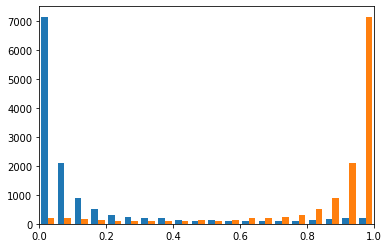

In [13]:
lr.fit(lr_X_train,lr_y_train)
lr_pred_proba = lr.predict_proba(lr_X_test)

plt.hist(lr_pred_proba,bins=20)
plt.xlim([0.0,1.0])

plt.show()

0.8394930964952466


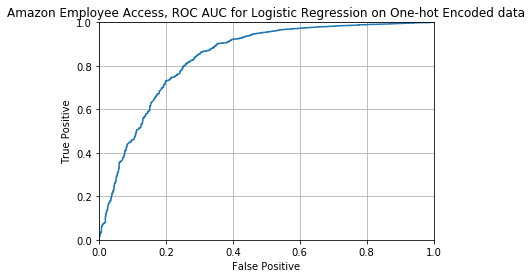

In [107]:
fpr, tpr, thresholds = roc_curve(lr_y_test.values,lr_pred_proba[:,1])
print(roc_auc_score(lr_y_test.values,lr_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access, ROC AUC for Logistic Regression on One-hot Encoded data")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

### Random forest

In [15]:
#убираем признак ROLE_CODE в связи с тем что он дублируется
train.pop("ROLE_CODE")
test.pop("ROLE_CODE")

0        117880
1        118865
2        118175
3        120774
4        118425
          ...  
58916    118786
58917    118055
58918    118279
58919    118322
58920    119435
Name: ROLE_CODE, Length: 58921, dtype: int64

In [108]:
# Соединяем тестовую и тренировочную выборку
rf_all_data = pd.concat([train, test],axis=0)
print("The all_data size is : {} ".format(rf_all_data.shape))

The all_data size is : (91690, 10) 


H:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [17]:
# Находим частоту встречаемости каждого признака
def add_counts(data):
    for col in data.columns: 
        count = data[col].value_counts()
        data['count_'+col] = data[col].replace(count)
    return data

train = add_counts(rf_all_data)

In [18]:
rf_train = rf_all_data.iloc[:y.shape[0]]
rf_test = rf_all_data.iloc[y.shape[0]:]

In [19]:
rf = RandomForestClassifier(criterion="gini",
                           n_estimators=300,#250
                            min_samples_split=9,
                            min_samples_leaf=3,
                            max_features=0.5,
                           random_state=66,
                           n_jobs=-1)

In [20]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_train, y, test_size=0.4)

In [63]:
rf.fit(rf_X_train,rf_y_train)
rf_pred_proba = rf.predict_proba(rf_X_test)

[[4.73905169e-02 9.52609483e-01]
 [8.32462260e-02 9.16753774e-01]
 [1.27290765e-02 9.87270924e-01]
 ...
 [7.53968254e-04 9.99246032e-01]
 [1.73880749e-02 9.82611925e-01]
 [2.21766104e-02 9.77823390e-01]]


0.8587150005526456


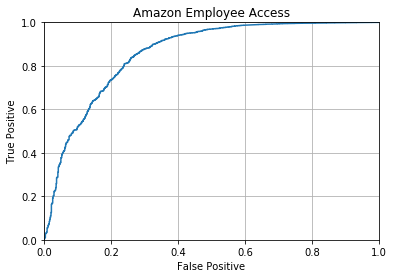

In [66]:
fpr, tpr, thresholds = roc_curve(rf_y_test.values,rf_pred_proba[:,1])
print(roc_auc_score(rf_y_test.values,rf_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access for Random Forest")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

#### Gradient boosting

In [24]:
gbc_train = rf_train
gbc_test = rf_test

In [25]:
from sklearn.preprocessing import StandardScaler 
SS = StandardScaler(copy=False, with_mean=True, with_std=True) 
SS.fit_transform(gbc_train)
SS.fit_transform(gbc_test)

array([[ 1.16802002,  1.3113764 ,  0.09720754, ...,  0.08437938,
        -0.49106582, -0.34020656],
       [ 0.03737748, -0.63553629,  0.08628703, ..., -0.73172713,
        -0.54167847, -0.695597  ],
       [ 1.06946472, -0.69201601,  0.08628703, ..., -0.77347051,
        -0.49179302, -0.95396075],
       ...,
       [-0.00361061, -0.58609161,  0.08628703, ..., -0.68458994,
        -0.47724915,  1.48059755],
       [-1.1377232 , -0.5131778 ,  0.08628703, ...,  2.01770755,
         2.06501849,  1.48059755],
       [ 0.16588789, -0.64863799,  0.08628703, ..., -0.67239525,
        -0.40278456, -0.30585014]])

0.836938366822399


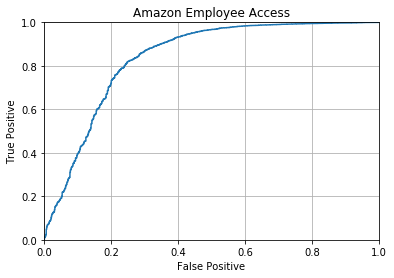

In [68]:
gbc = GradientBoostingClassifier(n_estimators=3000, min_samples_split=9)
gbc.fit(rf_X_train,rf_y_train)
gbc_pred_proba = gbc.predict_proba(rf_X_test)
fpr, tpr, thresholds = roc_curve(rf_y_test.values,gbc_pred_proba[:,1])
print(roc_auc_score(rf_y_test.values,gbc_pred_proba[:,1]))
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Amazon Employee Access")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

## Выводы

| Метод | Оценка |
| --- | --- |
| most frequent dummy classifier | 0.9421099209618847 |
| uniform dummy classifier | 0.4990387256248283 |
| stratified dummy classifier | 0.8905978211114163 |
| Decision Tree Classifier | 0.9311870613365884  |
| Bagging | 0.9485810192249008 |
| AdaBoost on Random Forest | 0.9493439121147391 |
| One-hot Encoded Logistic Regression | 0.8394930964952466 |
| One-hot encoded Random Forest | 0.8587150005526456 |
| Gradient Boosting on standartized data | 0.836938366822399 |